In [3]:
!pip install --upgrade sktime[all_extras]
!pip install tsai
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 16.3 MB/s eta 0:00:00
     ━━

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import warnings
import sktime
from datetime import datetime


sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

In [5]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
from sktime.forecasting.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
import pmdarima as pm


r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

In [6]:
try:
    df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

# DEF

In [7]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
def checkDuplicates(df):
    '''
    Checks for duplicates in the entire DataFrame.
    Returns a DataFrame with the duplicates.
    '''

    duplicate_mask = df.duplicated()

    duplicate_df = df[duplicate_mask]

    return duplicate_df

In [9]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [10]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
    return df_out

def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    df = df / 1000 # Convert from MW to GW
    df = df.rename_axis('Date')
    return df

def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

# Результаты предварительного анализа выбранного однопеременного ВР

In [11]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(f"Минимальная дата: {df['timestamp'].min().strftime('%Y-%m-%d')}, Максимальная дата: {df['timestamp'].max().strftime('%Y-%m-%d')}")


date_difference= df['timestamp'].max() - df['timestamp'].min()
print(f"Количество дней в промежутке: {date_difference.days} дней")

Минимальная дата: 2014-07-01, Максимальная дата: 2015-01-31
Количество дней в промежутке: 214 дней


In [13]:
df.set_index('timestamp', inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB


Теперь набор представляет собой запросы такси:
* timestamp — дата в формате гггг-мм-дд ч-м-с;
* value — Общее число запросов;

Проведем анализ сформированного набора данных

In [15]:
# Проверим дубликаты и пропуски в df
checkDuplicates(df)

,value
timestamp,
2014-07-03 11:30:00,16778
2014-07-03 14:30:00,19078
2014-07-05 01:30:00,12535
2014-07-06 00:30:00,14615
2014-07-06 11:00:00,11595
...,...
2015-01-31 17:00:00,20715
2015-01-31 17:30:00,23595
2015-01-31 20:00:00,24985


In [16]:
df.isnull().sum()

value    0
dtype: int64

In [17]:
print('Размерность набора данных:', df.shape)

Размерность набора данных: (10320, 1)


In [18]:
print(df.index.day)
print(df.index.weekday)
print(df.index.year)

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            31, 31, 31, 31, 31, 31, 31, 31, 31, 31],
           dtype='int64', name='timestamp', length=10320)
Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
           dtype='int64', name='timestamp', length=10320)
Int64Index([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
            ...
            2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015],
           dtype='int64', name='timestamp', length=10320)


In [19]:
df.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


* Теперь посмотрим на распределение запросов такси по неделям и месяцам;

In [20]:
df[['value']].loc['2014-07-01':'2014-12-31'].asfreq('W')

,value
timestamp,
2014-07-06,15427
2014-07-13,25792
2014-07-20,25137
2014-07-27,25659
2014-08-03,24613
2014-08-10,23701
2014-08-17,23263
2014-08-24,22666
2014-08-31,19205


In [21]:
df[['value']].asfreq('M')

,value
timestamp,
2014-07-31,15486
2014-08-31,19205
2014-09-30,9459
2014-10-31,19957
2014-11-30,20149
2014-12-31,14294
2015-01-31,25778


In [22]:
df.resample('1m').median()

,value
timestamp,
2014-07-31,16625.5
2014-08-31,16184.0
2014-09-30,17244.5
2014-10-31,17767.5
2014-11-30,17287.0
2014-12-31,16587.0
2015-01-31,16061.0


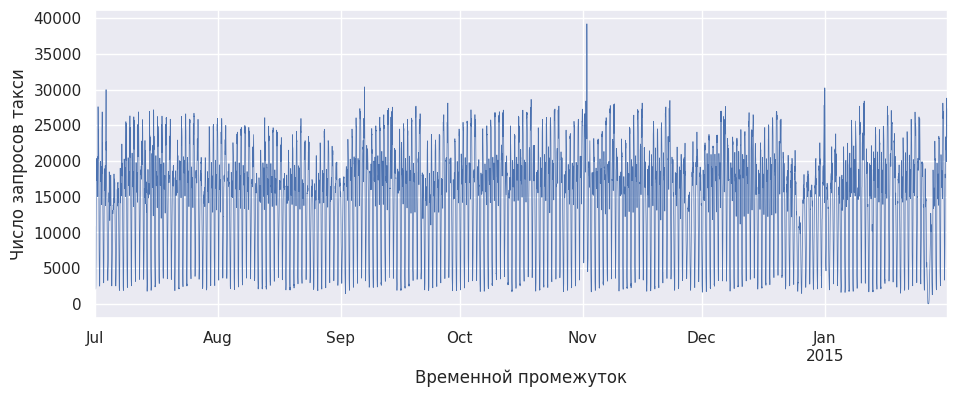

In [23]:
# linewidth=0.5 - толищина
df['value'].plot(linewidth=0.5)

plt.xlabel('Временной промежуток')
plt.ylabel('Число запросов такси')

plt.show();

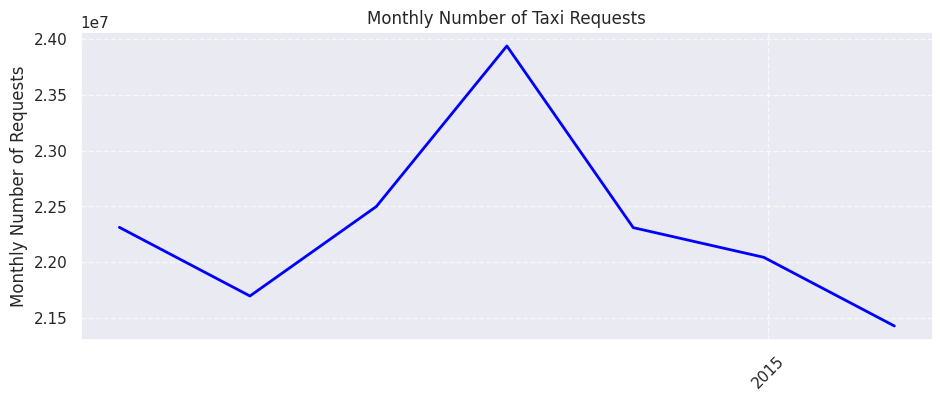

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_monthly = df.resample('M').sum(min_count=7)

# Получение осей
ax = plt.gca()

# График
ax.plot(df_monthly['value'], color='blue', linewidth=2, label='Total Value')  # Изменяем цвет и толщину линии

ax.xaxis.set_major_locator(mdates.YearLocator())  # Устанавливаем локатор для года
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Форматируем метки года

# Добавляем сетку
ax.grid(True, linestyle='--', alpha=0.7)

# Добавляем заголовок и метку оси Y
ax.set_title('Monthly Number of Taxi Requests')
ax.set_ylabel('Monthly Number of Requests')

# Поворачиваем метки по оси X для лучшей читаемости
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Отображаем график
#plt.tight_layout()  # Решаем проблемы с наложением элементов
plt.show()

* Посмотрим также распределение по неделям, для более наглядного графика.

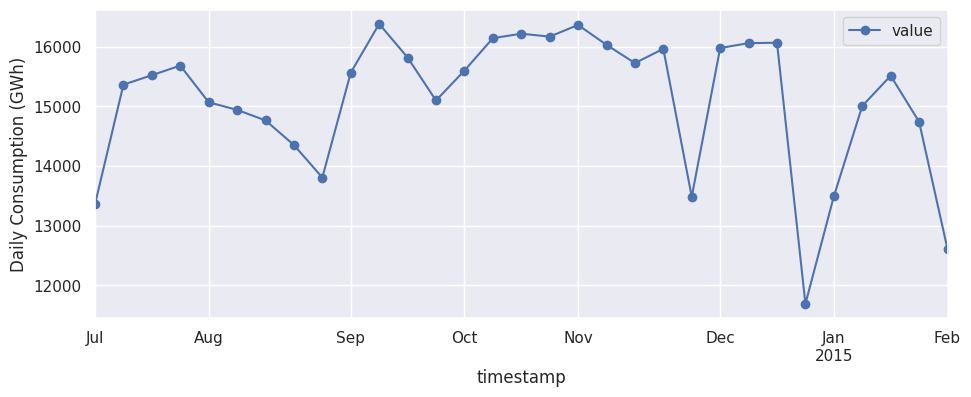

In [25]:
ax = df.resample('W').mean().plot(marker='o', linestyle='-',linewidth=1.5)
ax.set_ylabel('Daily Consumption (GWh)')
plt.show();

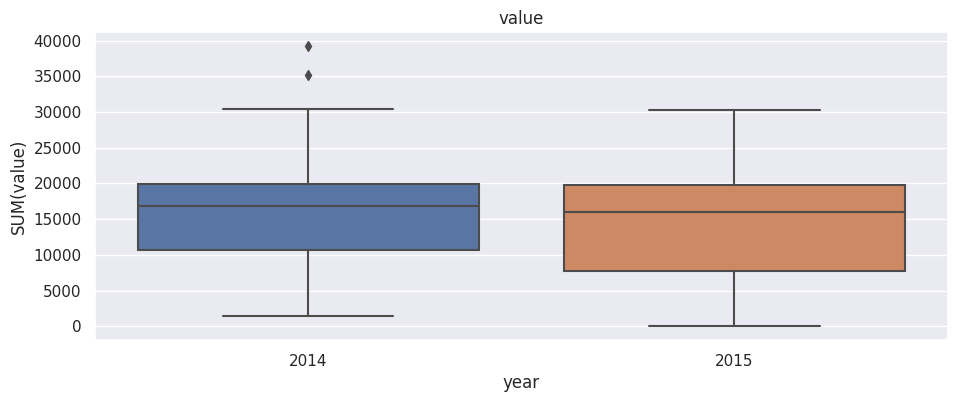

In [26]:
#BBox

ax = sns.boxplot(data=df, x=df.index.year, y='value')
ax.set_ylabel('SUM(value)')
ax.set_xlabel('year')
ax.set_title('value')
plt.show();

* Сезонность дней недели
  * можно заметить что к выходным спрос повышается, но ничего не обычного нет

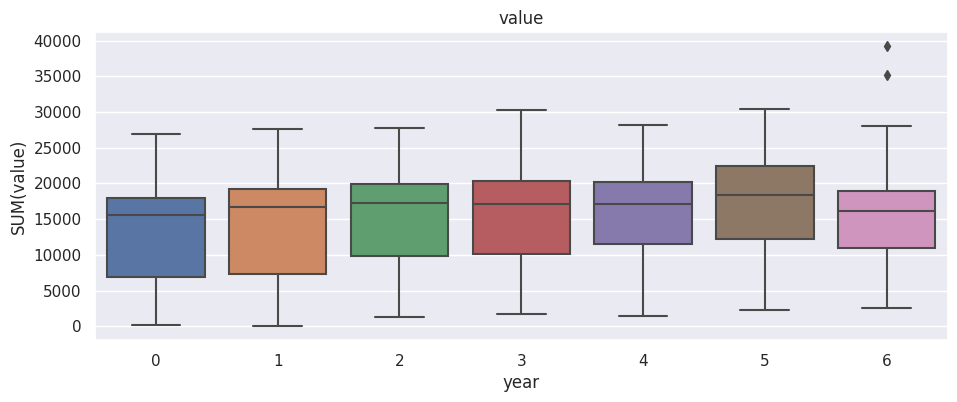

In [27]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='value');
ax.set_ylabel('SUM(value)')
ax.set_xlabel('year')
ax.set_title('value')
plt.show()

* Анализ полученных графиков показывает следующее:
  * Графики показывают, что присутствует сезонность, с приходом холодов (Конец Августа - частота запросов такси находятся на пике)
  * Также можно заметить - большой спад, в конце года спрос падает на минимальный уровень(К праздникам подготовились, все находятся дома)
  * В 2014 году видны выбросы, 2015 год можно не учитывать, слишком мало данных за год





# Сравнение не менее 3-х методов предсказаний значений ВР по выбранной метрике точности и визуально. Соответственно рекомендации по выбору метода.

## TRAIN_TEST_SPLIT

In [28]:
# Сразу определим оценку модели
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 419.3 KB


In [31]:
y = df.value.asfreq('7d')
# y.index = pd.PeriodIndex(y.index) # pd.to_datetime(y.index)
y.head()

timestamp
2014-07-01    10844
2014-07-08     9292
2014-07-15    10089
2014-07-22    10611
2014-07-29    10468
Freq: 7D, Name: value, dtype: int64

* Сгруппируем по дням и просуммируем значения
  * Без четкого определения данных сложно сказать что конкретнно подразумевается под запросами такси. Пусть счетчик подсчитывал каждые 30 минут количество "запросов", тогда можно будет с уверенность просуммировать данные по дням и начать сравнение 3-х методов предсказания значений.

In [32]:
#df.index = pd.to_datetime(df.index)
df_grouped = df.resample('D').sum()


df_grouped.head()

,value
timestamp,
2014-07-01,745967
2014-07-02,733640
2014-07-03,710142
2014-07-04,552565
2014-07-05,555470


In [33]:
y = df_grouped.value.asfreq('1d')
# y.index = pd.PeriodIndex(y.index) # pd.to_datetime(y.index)
y.tail()

timestamp
2015-01-27    232058
2015-01-28    621483
2015-01-29    704935
2015-01-30    800478
2015-01-31    897719
Freq: D, Name: value, dtype: int64

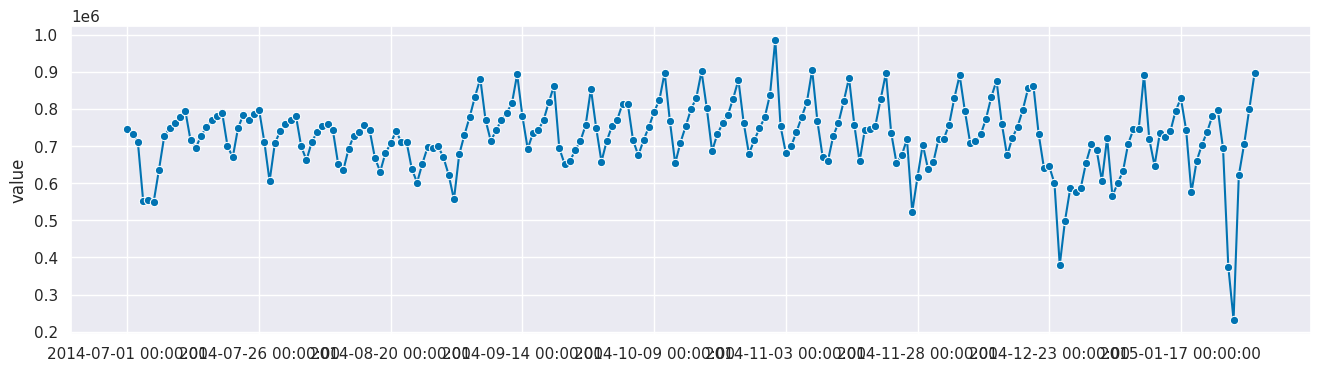

In [34]:
sktime.utils.plotting.plot_series(y);

Check splitted data size: Train: 119, Test: 96


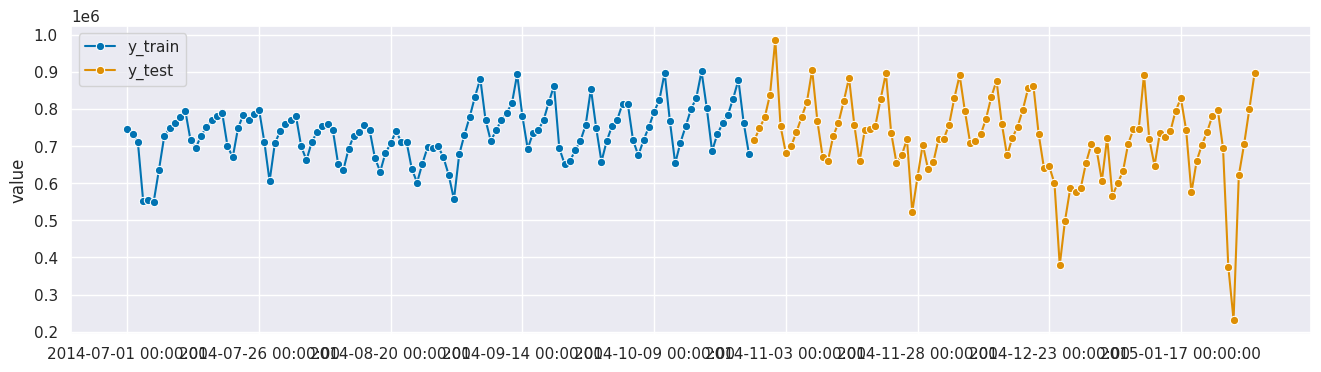

In [35]:
TEST_SIZE = int(0.45*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

sMAPE = 0.134


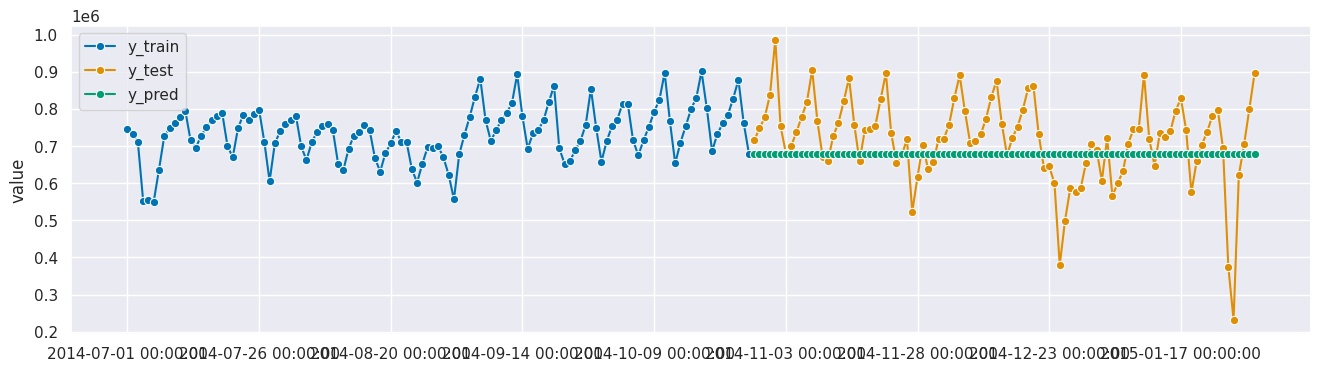

In [36]:
# ГОРИЗОНТ

#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

### Наивное сезонное предсказание

sMAPE = 0.130


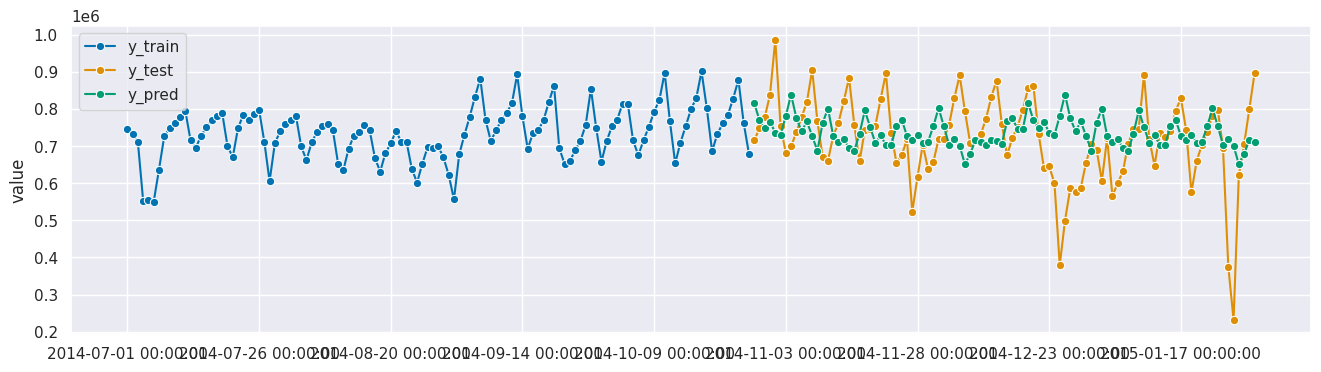

In [37]:
SEASON = 52

forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

### Simple Exponential Smoothing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


sMAPE = 0.134


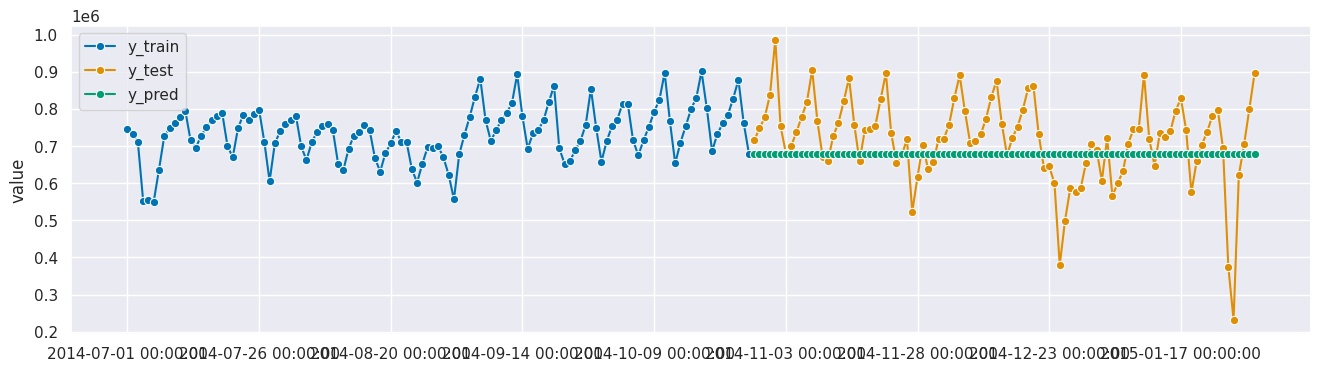

In [38]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


sMAPE = 0.257


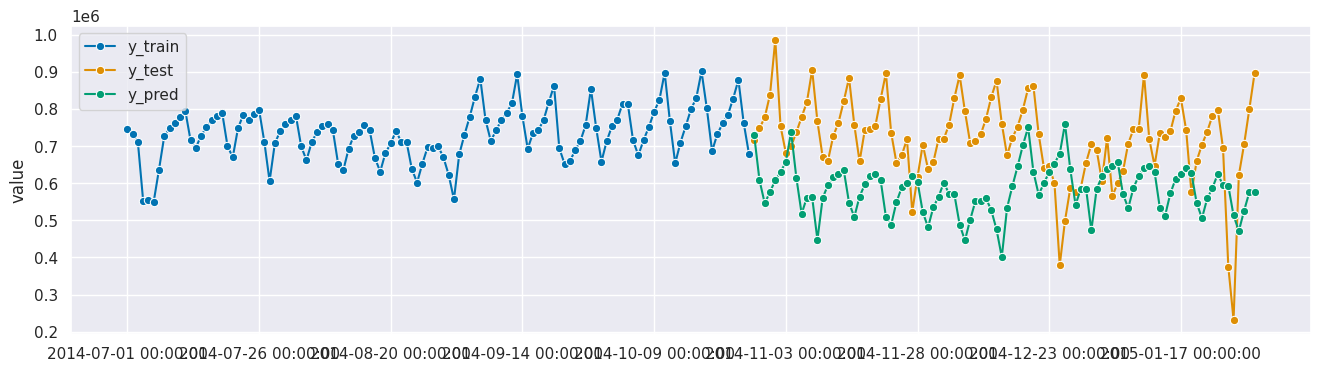

In [39]:
SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
forecaster = EnsembleForecaster(
    [
#         ("ses", ses),
#         ("holt", holt),
#         ("damped", damped_holt),
        ("holt-winter",holt_winter),
#         ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
#         ("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
#         ("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)
    ]
)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

### KNeighborsRegressor

sMAPE = 0.101


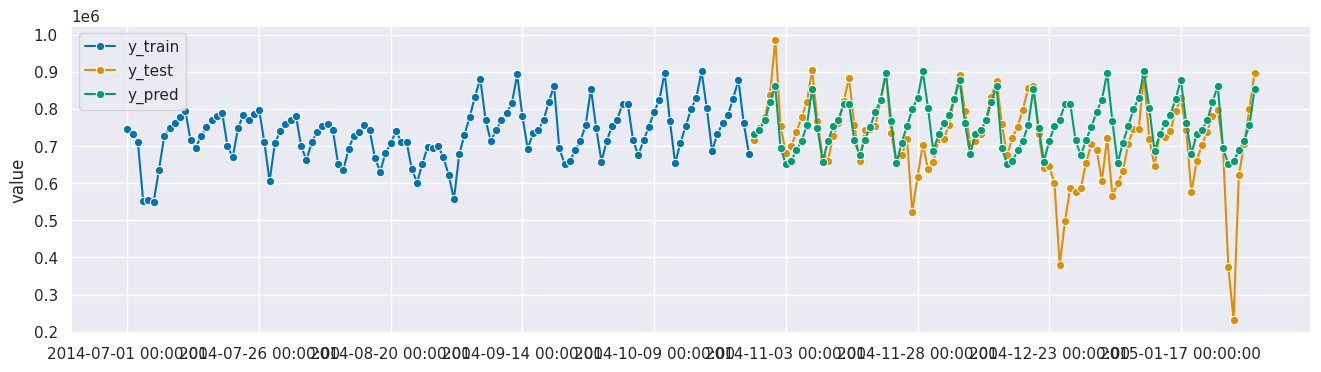

In [40]:
from sklearn.neighbors import KNeighborsRegressor

REGRESSION_WINDOW = 15

regressor  = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

### ThetaForecaster

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


sMAPE = 0.219


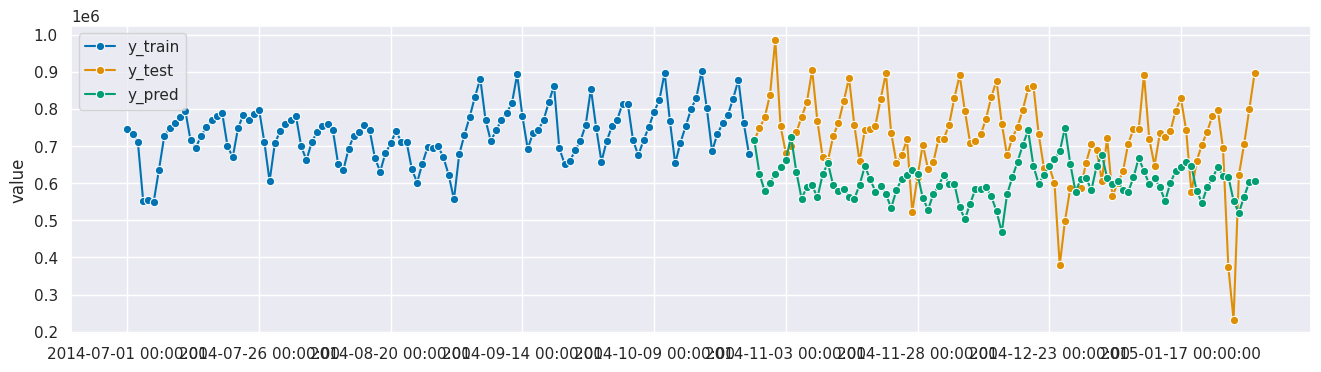

In [41]:
forecaster = ThetaForecaster(sp=SEASON)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

# Отчет о выборе параметров модели SARIMA (можно в режиме автовыбора или ручном режиме, возможна их комбинация). Отчет также должен включать описание остаточной части предсказания.

## Проверка стационарности

In [42]:
P_THRESHOLD = 0.05
def check_ADF(y, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Result: The series is {"not " if p_value < p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

ADF Statistic: -3.4141
p-value: 0.0105
Critical Values:
	1%: -3.4912, outperformed
	5%: -2.8882, 
	10%: -2.5810, 
Result: The series is not stationary


In [43]:
y_sdif = y_train[:].diff(1).diff(SEASON).dropna()
results = check_ADF(y_sdif);

ADF Statistic: -3.8985
p-value: 0.0020
Critical Values:
	1%: -3.5507, 
	5%: -2.9138, 
	10%: -2.5946, 
Result: The series is not stationary


In [44]:
y_sdif = y_train[:].diff(2).diff(SEASON).dropna()
results = check_ADF(y_sdif);

ADF Statistic: -4.2100
p-value: 0.0006
Critical Values:
	1%: -3.5507, 
	5%: -2.9138, 
	10%: -2.5946, 
Result: The series is not stationary


In [45]:
y_sdif = y_train[:].diff(3).diff(SEASON).dropna()
results = check_ADF(y_sdif);

ADF Statistic: -1.7962
p-value: 0.3823
Critical Values:
	1%: -3.5629, outperformed
	5%: -2.9190, outperformed
	10%: -2.5974, outperformed
Result: The series is stationary


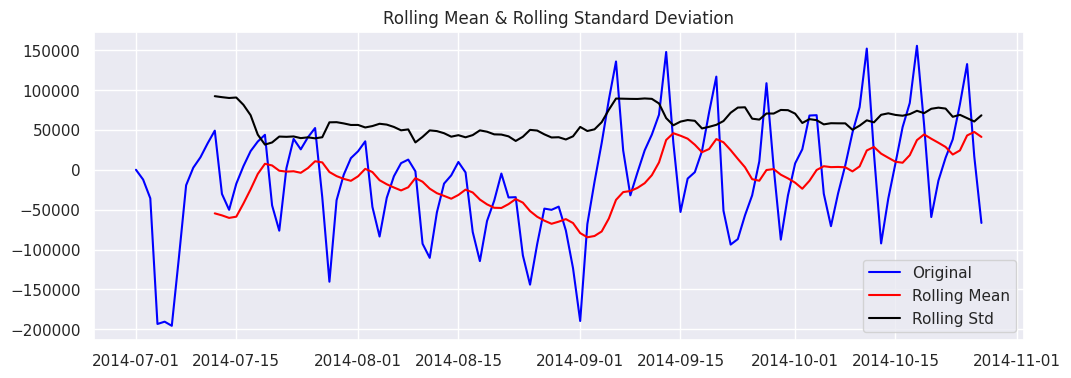

In [46]:
rolling_mean = y_train.rolling(window = 12).mean()
rolling_std  = y_train.rolling(window = 12).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train-y_train[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-y_train[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show();

* Сделали проверку на стационарность временного ряда с использованием теста на наличие единичного корня (ADF-тест).
Вывод:

  * value равно 0.0105, что меньше порога в 0.05. Таким образом данные не соответствуют критерию стационарности, поскольку p-value меньше уровня значимости.



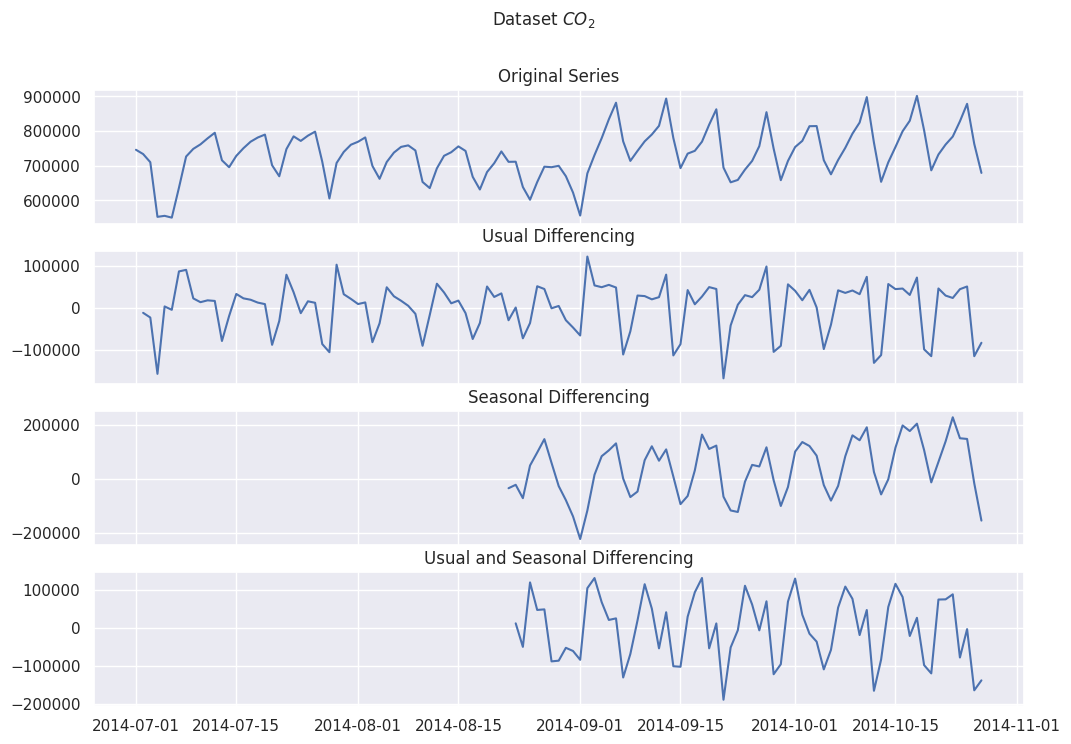

In [47]:
SEASON = 52

fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y_train[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y_train[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y_train[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y_train[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show();

## Model

In [48]:
from sktime.forecasting.arima import AutoARIMA

model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=0,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=5,    # конечный порядок MA
                  seasonal=True,  # Использовать SARIMA
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 7, # Максимальный порядок p+q+P+Q
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=1689.955, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=1690.001, Time=0.38 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=1690.123, Time=9.15 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=1688.205, Time=7.53 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1702.126, Time=0.53 sec
 ARIMA(0,1,1)(0,1,0)[52] intercept   : AIC=1689.950, Time=1.27 sec
 ARIMA(0,1,1)(1,1,1)[52] intercept   : AIC=inf, Time=17.24 sec
 ARIMA(0,1,1)(0,1,2)[52] intercept   : AIC=inf, Time=18.07 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1690.049, Time=1.86 sec
 ARIMA(0,1,1)(1,1,2)[52] intercept   : AIC=inf, Time=19.78 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=1689.267, Time=2.87 sec
 ARIMA(1,1,1)(0,1,1)[52] intercept   : AIC=1690.139, Time=7.08 sec
 ARIMA(0,1,2)(0,1,1)[52] intercept   : AIC=1690.172, Time=6.61 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=1688.427, Time=2.56 sec
 ARIMA(1,1,2)(0,1,1)[52] interc

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -840.133
Date:                            Mon, 27 Nov 2023   AIC                           1686.267
Time:                                    05:42:20   BIC                           1692.836
Sample:                                07-01-2014   HQIC                          1688.863
                                     - 10-27-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1660      0.091      1.821      0.069      -0.013       0.345
ma.S.L52      -0.3238      0.086     -3.754      0.000      -0.493      -0.155
sigma2      6.931e+09   3.67e-12   1.89e+21      0.000    6.93e+09    6.93e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):                 5.64
Prob(Q):                              0.31   Prob(JB):                         0.06
Heteroskedasticity (H):               2.03   Skew:                            -0.70
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [49]:
smape_value = smape(y_test, y_pred)
print(f"sMAPE: {smape_value}")

sMAPE: 0.2187027360998355


In [50]:
forecaster = SARIMAX(order=(3, 1, 0), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_sdif)
print(forecaster.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   64
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -145.608
Date:                            Mon, 27 Nov 2023   AIC                            301.216
Time:                                    05:42:22   BIC                            303.205
Sample:                                08-25-2014   HQIC                           299.961
                                     - 10-27-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.074e+04   5.27e+04     -0.583      0.560   -1.34e+05    7.26e+04
ar.L1          0.3465      0.334   

```
Параметры модели:
```
* Выбранная модель SARIMA имеет параметры (3, 1, 0) без сезонных компонент (p, d, q) и (0, 1, 0, 52) для сезонной составляющей (P, D, Q, s).
* Данная спецификация указывает, что в модели применено первое разностное преобразование временного ряда, авторегрессионные компоненты ar.L1, ar.L2 и ar.L3, и отсутствуют скользящие средние.
* Сезонная составляющая также предполагает первое сезонное разностное преобразование.

```
Метрики качества модели:
```

* Логарифмическое правдоподобие (Log Likelihood) составляет -145.608.
* Значение AIC равно 301.216, что является критерием информативности модели. * * Меньшие значения AIC сигнализируют о лучшей подгонке модели.

```
Коэффициент дисперсии (sigma2):
```
* Коэффициент дисперсии (sigma2) равен 1.42e+10, что предоставляет оценку дисперсии остатков модели.

```
Диагностические тесты:
```

* Ljung-Box тест (Q) на первом лаге (L1) имеет p-значение 0.95, что свидетельствует о автокорреляции в остатках отсутствует на первом лаге.
* Jarque-Bera тест (JB) на нормальность остатков имеет p-значение 0.84, что не отвергает гипотезу о нормальности остатков. В этом случае, остатки подчиняются нормальному распределению.

```
Гетероскедастичность:
```

* Тест на гетероскедастичность (H) имеет p-значение 0.85, что не достаточно низкое для отвержения гипотезы о гетероскедастичности в остатках.
Коэффициенты модели:

* Intercept имеет значение -3.074e+04 со стандартной ошибкой 5.27e+04. P-значение равно 0.560, что не позволяет отвергнуть гипотезу о том, что коэффициент не отличается от нуля.

* Коэффициенты авторегрессии (ar.L1, ar.L2, ar.L3) не являются статистически значимыми при уровне значимости 0.05, что может указывать на их несущественность в модели.

```
Выводы:
```
* Модель SARIMA с параметрами (3, 1, 0)x(0, 1, 0, 52) имеет низкое значение AIC, что указывает на хорошее качество подгонки к данным.
Диагностические тесты не выявили автокорреляцию в остатках, но не исключают возможности гетероскедастичности.
* Важно также обратить внимание на нестатистически значимые коэффициенты авторегрессии и наличие предупреждений относительно возможных проблем с оценкой коэффициентов (условие номер [1] и [2]). Дополнительные исследования и коррекции могут быть необходимы для улучшения модели.

# Сравнение выбранных методов предсказаний и результатов работы настроенной модели SARIMA.


```
Простое экспоненциальное сглаживание:
   - sMAPE: 0.134.

 KNeighborsRegressor:
   - sMAPE: 0.101.

 ThetaForecaster:
   - sMAPE: 0.219.

 Модель SARIMA:
   - sMAPE: 0.1304.
```


* **KNeighborsRegressor** демонстрирует наименьшее значение sMAPE (0.101), что указывает на лучшую точность прогнозирования среди представленных методов.

* **SARIMA** также показывает хороший результат с sMAPE 0.1304, приближаясь к точности простого экспоненциального сглаживания.

* **Простое экспоненциальное сглаживание** имеет sMAPE 0.134, что также является конкурентоспособным результатом.

* **ThetaForecaster** имеет более высокое значение sMAPE (0.219), что указывает на менее точные прогнозы по сравнению с другими методами.

C основным критерием оценик sMAPE, то **KNeighborsRegressor** показывает наилучшие результаты, за ним следует **SARIMA**, и затем **Простое экспоненциальное сглаживание**. **ThetaForecaster** показывает наименьшую точность среди представленных методов.

# Аналогично примерам (классификация временных рядов) анализ выбранного однопеременного ряда на предмет классификации его сегментов. Задачу можно сформулировать самостоятельно, например, как синтетическую для того же набора данных, который использовался для предсказания. Можно выбрать и новый набор данных. Результатом анализа должна быть таблица не менее чем из 3-х методов, которые сравнены по точности.

## Предобработка

In [51]:
try:
    df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv', index_col='timestamp', parse_dates=True)

except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10320 entries, 2014-07-01 00:00:00 to 2015-01-31 23:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   10320 non-null  int64
dtypes: int64(1)
memory usage: 161.2 KB


In [53]:
df['day_of_the_week'] = pd.to_datetime(df.index).weekday

In [54]:
winter = to_segments(split_by_month(df, [1, 2, 12]), 'value', size=24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'value', size=24)
autumn = to_segments(split_by_month(df, [9, 10, 11]), 'value', size=24)

print(winter.shape, summer.shape, autumn.shape)

(123, 24) (123, 24) (181, 24)


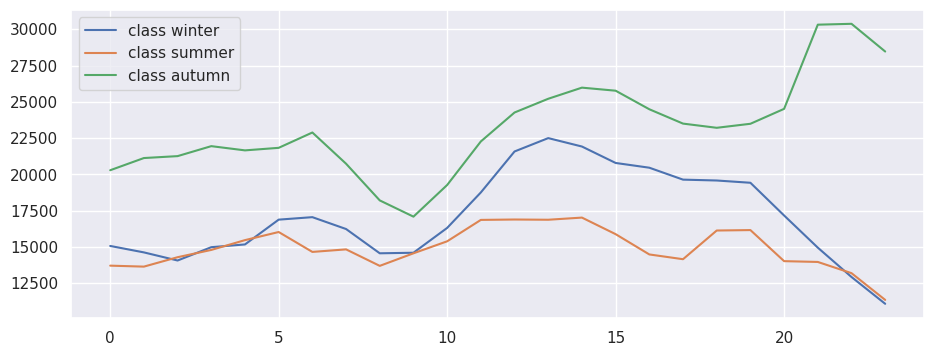

In [55]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn],['winter','summer','autumn'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

In [56]:
# weekday - будние дни (пн-пт)
weekday = df[(df['day_of_the_week'] >= 1) & (df['day_of_the_week'] <= 5)]

# weekend - выходные (сб-вс)
weekend = df[(df['day_of_the_week'] == 0) | (df['day_of_the_week'] == 6)]

In [57]:
print(weekday.shape, weekend.shape)

(7440, 2) (2880, 2)


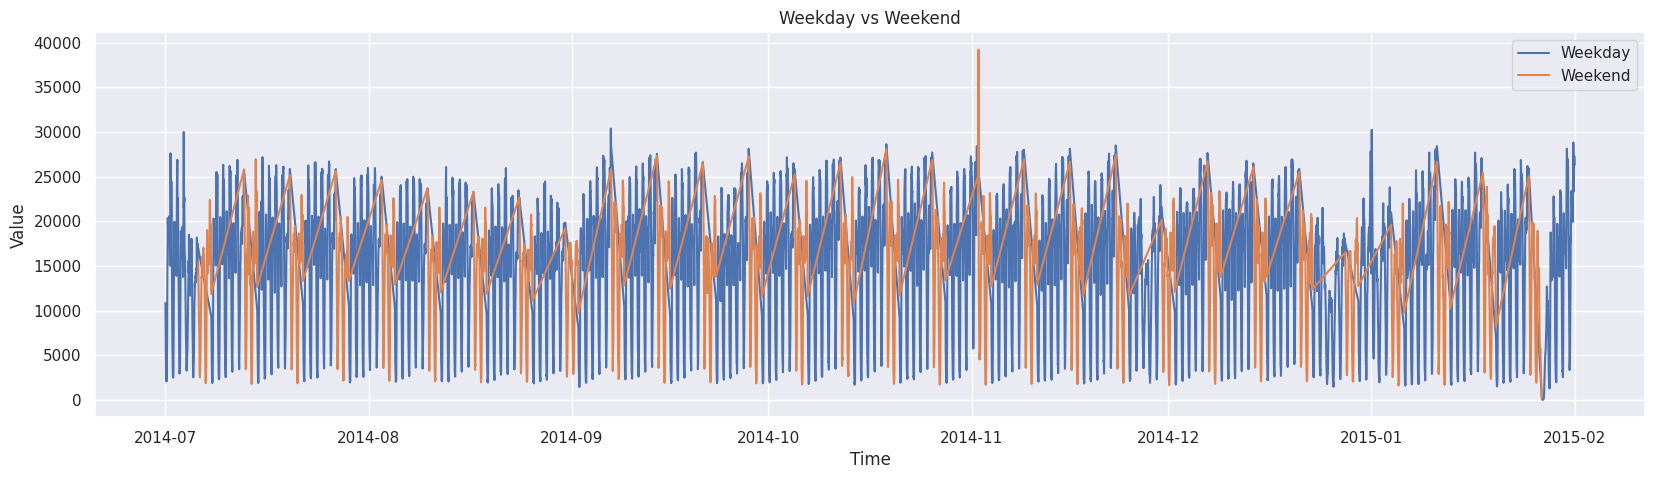

In [58]:
# Постройте графики для будних и выходных
plt.figure(figsize=(20, 5))

plt.plot(weekday['value'], label='Weekday')
plt.plot(weekend['value'], label='Weekend')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Weekday vs Weekend')
plt.legend(loc='best')

plt.show()

## Классификация

In [59]:
from sklearn.model_selection import train_test_split


X = np.concatenate((
                    weekday,
                    weekend))


y = np.concatenate((
                    0*np.ones(weekday.shape[0]),
                    1*np.ones(weekend.shape[0])
                   ))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7224, 2) (7224,) (3096, 2) (3096,)


### Модели

#### TimeSeriesForestClassifier

In [60]:
from sktime.classification.interval_based import TimeSeriesForestClassifier

clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)
tsf_score = clf.score(X_test, y_test)

print(f' Score {clf.score(X_test, y_test):.3f}')

 Score 0.663


#### RidgeClassifierCV

In [61]:
from sklearn.linear_model import RidgeClassifierCV

# Assuming X_train, X_test, y_train, y_test are defined

# RidgeClassifierCV
ridge_clf = RidgeClassifierCV()
ridge_clf.fit(X_train, y_train)

# Evaluate the model on the test set
ridge_score = ridge_clf.score(X_test, y_test)
print(f'Test score with RidgeClassifierCV: {ridge_score:.3f}')

Test score with RidgeClassifierCV: 0.728


#### KNeighborsTimeSeries

In [62]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
knn_score = knn_clf.score(X_test, y_test)

print(f'Score with K-nearest neighbors: {knn_clf.score(X_test, y_test):.3f}')

Score with K-nearest neighbors: 0.688


### Сравнение

In [63]:
results = pd.DataFrame({
    'Model': ['TimeSeriesForest', 'RidgeClassifier', 'KNeighborsTimeSeries'],
    'Score': [tsf_score, ridge_score, knn_score]
})
results

,Model,Score
0,TimeSeriesForest,0.662791
1,RidgeClassifier,0.728036
2,KNeighborsTimeSeries,0.687984


* TimeSeriesForest (0.662791): Эта модель использует алгоритм леса решений для временных рядов.

* RidgeClassifier (0.728036): Эта модель использует линейный классификатор Ridge.

* KNeighborsTimeSeries (0.687984): Эта модель использует метод k-ближайших соседей для временных рядов.

      - RidgeClassifier продемонстрировал наилучшую производительность среди трех моделей с точностью в 72.8% - набор данных имеет линейные зависимости.                        


# Отчет об исследовании выбранной задачи классификации  при помощи глубоких нейронных сетей в пакете tsai. Исследование может быть проведено аналогично примеру. Результат анализа — рекомендованная архитектура нейронной сети. Архитектура должна быть сравнена с методами классификации из пункта выше.

## Загрузка данных

In [65]:
from tsai.all import *
import warnings
from sklearn.model_selection import train_test_split
import torch
from torch import nn

In [66]:
computer_setup()

os              : Linux-5.15.120+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.0+cu118
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


In [89]:
try:
    df = pd.read_csv('https://raw.githubusercontent.com/v-onuphrienko/Project.Study/main/14.%20HW1_ML_base/time_series_60.csv', sep=';')

except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50398 entries, 0 to 50397
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  50398 non-null  object 
 1   entsoe    50398 non-null  float64
dtypes: float64(1), object(1)
memory usage: 787.6+ KB


In [92]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [93]:
df

,entsoe
datetime,
2015-01-01 01:00:00+00:00,1794.96
2015-01-01 02:00:00+00:00,1744.76
2015-01-01 03:00:00+00:00,1743.17
2015-01-01 04:00:00+00:00,1751.47
2015-01-01 05:00:00+00:00,1767.16
...,...
2020-09-30 18:00:00+00:00,2801.24
2020-09-30 19:00:00+00:00,2615.98
2020-09-30 20:00:00+00:00,2219.68


## Преобразование

In [95]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'entsoe', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'entsoe', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'entsoe', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'entsoe', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

X = np.concatenate((
                    winter,
                    summer,
                    autumn,
                    spring))
y = np.concatenate((
                    1*np.ones(winter.shape[0]),
                    2*np.ones(summer.shape[0]),
                    3*np.ones(autumn.shape[0]),
                    4*np.ones(spring.shape[0])
                   ))


X = np.atleast_3d(X).transpose(0,2,1)
y.astype(int)

(510, 24) (551, 24) (483, 24) (551, 24)


array([1, 1, 1, ..., 4, 4, 4])

In [96]:
class_map = {
    1:'winter',
    2:'summer',
    3:'autumn',
    4:'spring',
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y)

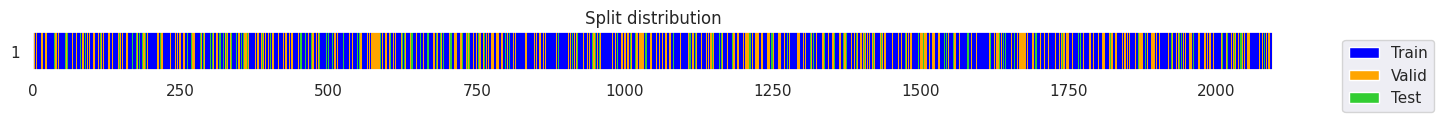

((#1258) [1276,1208,1046,1274,1487,631,1389,1166,1974,86...],
 (#628) [678,1677,1547,1846,1399,398,1267,1672,648,1031...],
 (#209) [1163,335,1275,113,80,950,288,493,470,548...])

In [97]:
splits = get_splits(y,
                    n_splits=1,
                    valid_size=0.3,
                    test_size=0.1,
                    shuffle=True,
                    balance=False,
                    stratify=True,
                    random_state=42,
                    show_plot=True,
                    verbose=True)
splits

* n_splits=1: - разделение
* valid_size=0.3: доля данных, включаемых в валидационный набор.
* test_size=0.1: доля данных, включаемых в тестовый набор.
* shuffle=True: перемешивание данных перед разделением.
* balance=False: отсутствие балансировки данных.
* stratify=True: стратификация разделения, что означает сохранение распределения классов в каждом разделении.
* random_state=42: задание случайного семени для воспроизводимости.
* show_plot=True: отображение графика разделения.
* verbose=True: отображение дополнительной информации о разделении.

- Создадим набор данных класса TSDatasets. В наборе данных зададим разделение данных и необходимые преобразования tfms.

- *Также* сконфигурируем загрузчик батчей TSDataLoaders. Загрузим тренировочный и валидационный наборы данных.

In [99]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 4
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

* bs - размер батча
* TSDataLoaders.from_dsets - метод, используемый для создания загрузчиков данных для обучающего и валидационного наборов.
* dsets.train и dsets.valid - это обучающий и валидационный наборы данных.
* bs=[bs, bs*2] - размер пакета для обучающего и валидационного загрузчиков данных.

In [101]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),
         (LSTM,    {'n_layers':3, 'bidirectional': False}),
         (RNN,     {'n_layers':3, 'bidirectional': True} ),
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),
         (ResNet, {}),
         (InceptionTime, {}),
         (XceptionTime,  {}),
         (TCN, {}),
         (LSTM_FCN, {}),
         (TST, {}),
         (FCN, {}),
        ]

## Model

In [102]:
from IPython.display import clear_output



results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):

    model = create_model(arch, dls=dls, **k)

    print(model.__class__.__name__)

    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(5, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,FCN,{},285188,0.690505,0.549458,0.840764,23
1,LSTM_FCN,{},326788,0.693379,0.562783,0.835987,37
2,InceptionTime,{},459780,0.690827,0.526885,0.826433,58
3,XceptionTime,{},403160,0.987582,0.684259,0.807325,90
4,ResNet,{},490500,0.855130,0.754525,0.765924,54
5,TST,{},399748,0.857263,0.934935,0.743631,38
6,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",207204,1.287557,1.278174,0.385350,24
7,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",73604,1.348353,1.329404,0.385350,14
8,RNN,"{'n_layers': 3, 'bidirectional': True}",146804,1.374537,1.373512,0.269108,22
9,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",146804,1.386506,1.385016,0.262739,27


SuggestedLRs(valley=3.630780702224001e-05)

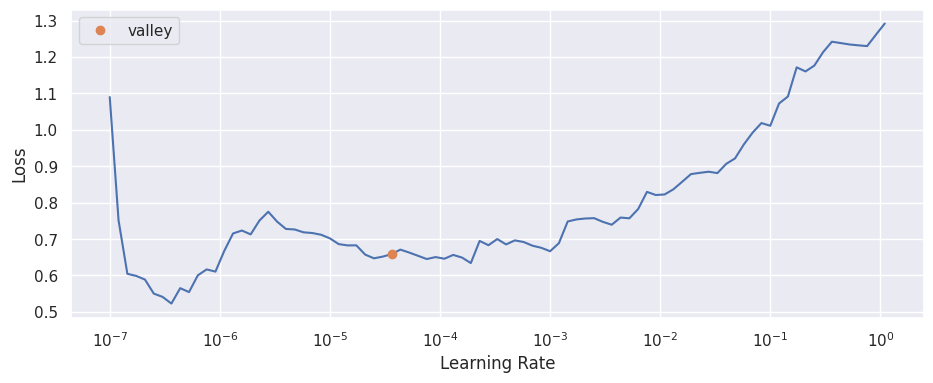

In [104]:
learn = ts_learner(dls, arch=model, metrics=accuracy)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.657502,0.554984,0.851911,00:07
1,0.725066,0.517293,0.831210,00:09
2,0.679380,0.555060,0.816879,00:03
3,0.607032,0.701990,0.781847,00:04
4,0.733382,0.601447,0.802548,00:06
5,0.691619,0.576224,0.788217,00:04
6,0.744091,0.794025,0.648089,00:03
7,0.777954,0.595133,0.748408,00:05
8,0.746021,0.871672,0.608280,00:05
9,0.841622,1.019393,0.667197,00:03


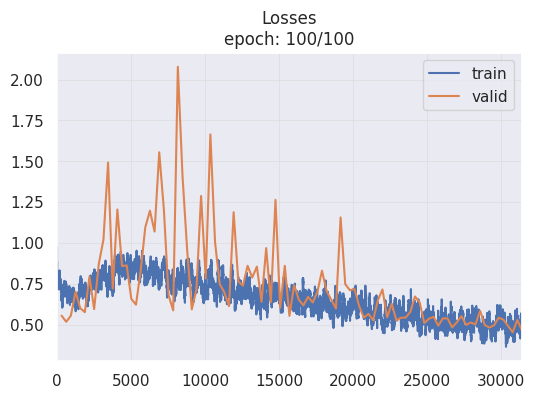

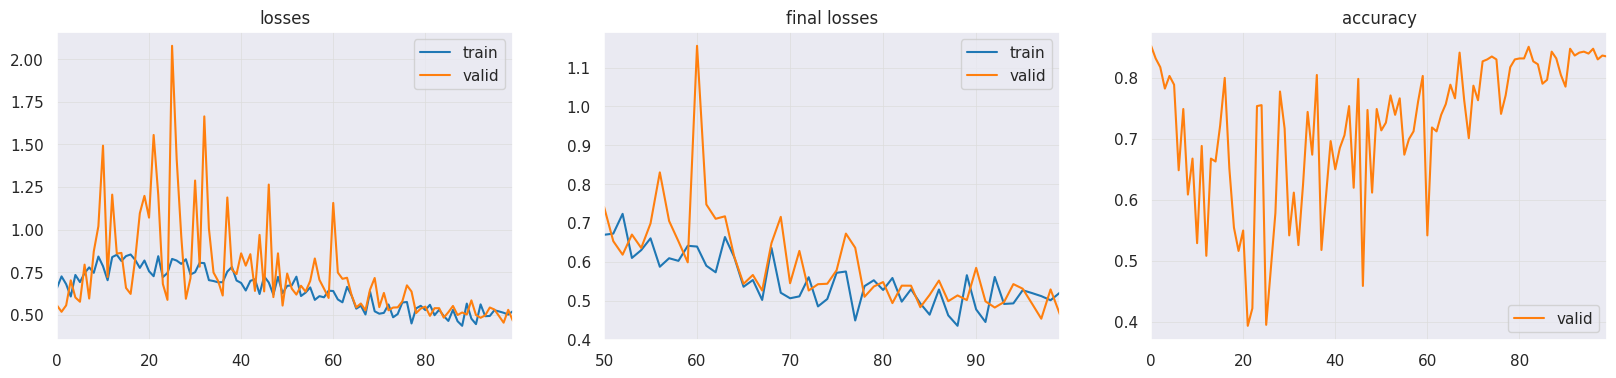

In [105]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.0036, cbs=ShowGraph())

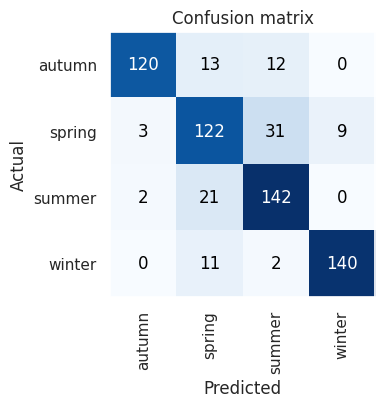

In [106]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

* Осень-Зима достаточно не плохо определена, Лето-Весна чуть хуже отрабатывает

In [109]:
# Выведем наиболее ошибочные случаи из матрицы
interp.most_confused(min_val=3)

[('spring', 'summer', 31),
 ('summer', 'spring', 21),
 ('autumn', 'spring', 13),
 ('autumn', 'summer', 12),
 ('winter', 'spring', 11),
 ('spring', 'winter', 9),
 ('spring', 'autumn', 3)]

In [110]:
probas, _, preds = learn.get_X_preds(X[splits[2][:5]])
preds, y[splits[2][:5]]

("['autumn', 'winter', 'autumn', 'winter', 'winter']",
 array(['autumn', 'winter', 'autumn', 'winter', 'winter'], dtype='<U6'))

In [114]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

class_map = {
    'winter':3,
    'summer':2,
    'autumn':0,
    'spring':1,
    }
class_map

labeler = ReLabeler(class_map)

In [115]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))

0.861244019138756

In [119]:
# Преобразование строковых меток в числовые
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labeler(y[splits[2]]))

# Вычисление точности
acc_tsai = accuracy_score(np.argmax(probas, axis=-1), numeric_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.861244019138756


In [120]:
acc_tsai

0.861244019138756

## Сравнение

In [121]:
results = pd.DataFrame({
    'Model': ['TimeSeriesForest', 'RidgeClassifier', 'KNeighborsTimeSeries', 'tsai_result'],
    'Score': [tsf_score, ridge_score, knn_score, acc_tsai]
})
results

,Model,Score
0,TimeSeriesForest,0.662791
1,RidgeClassifier,0.728036
2,KNeighborsTimeSeries,0.687984
3,tsai_result,0.861244


* Как мы видим, новая модель работает на порядок лучше TimeSeriesForest, RidgeClassifier, KNeighborsTimeSeries

# Отчет о выявлении аномалий во временном ряду. Может быть выбран ВР, использованный ранее. Отчет должен включать результаты анализа не менее чем 3-х методов аналогичных тем, что в примерах. Отчет может быть произведен в текстовом виде, например, как наиболее частые типы аномалий или гипотезы о причинах их появления. Также в отчет можно включить рекомендации по выбору и настройке методов выявления аномалий.

## QuantileAD

* QuantileAD - метод использования квантилей.
  * Выставим минимальные пороги квантилей

In [125]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df)
print('Число аномальных выбросов:', anomalies.values.sum())

Число аномальных выбросов: 1008


In [130]:
df.head

<bound method NDFrame.head of                             entsoe
datetime                          
2015-01-01 01:00:00+00:00  1794.96
2015-01-01 02:00:00+00:00  1744.76
2015-01-01 03:00:00+00:00  1743.17
2015-01-01 04:00:00+00:00  1751.47
2015-01-01 05:00:00+00:00  1767.16
...                            ...
2020-09-30 18:00:00+00:00  2801.24
2020-09-30 19:00:00+00:00  2615.98
2020-09-30 20:00:00+00:00  2219.68
2020-09-30 21:00:00+00:00  1940.76
2020-09-30 22:00:00+00:00  1826.01

[50398 rows x 1 columns]>

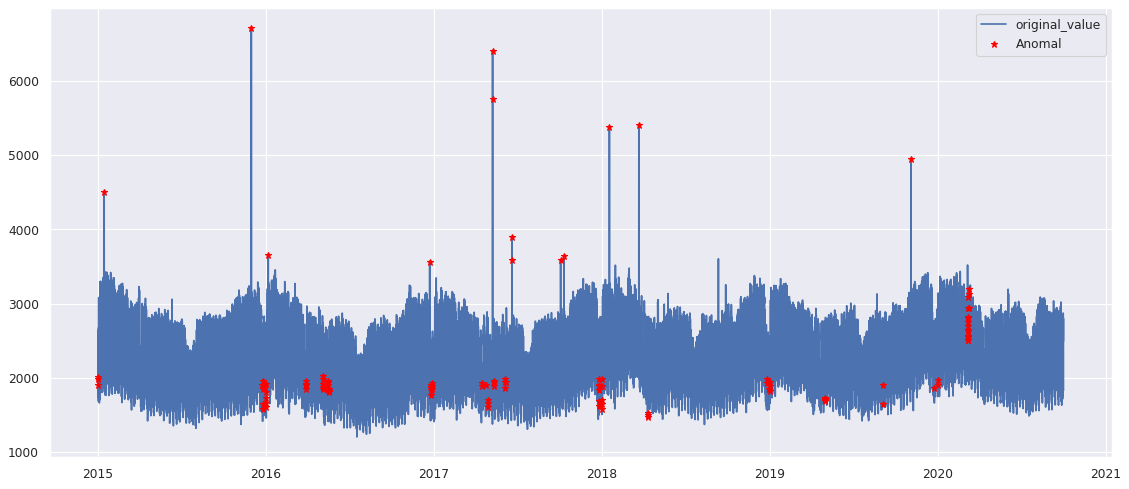

In [145]:
df2 = df.copy()
df2['a'] = anomalies['entsoe']
df_all = df2[df2['a'] == True].copy()

figure(figsize=(14, 6), dpi=80, layout='constrained')
plt.plot(df['entsoe'], label='original_value')
plt.plot(df_all['entsoe'], color='red', marker='*', linestyle='', label='Anomal')
plt.legend()
plt.show();


## SeasonalAD

* SeasonalAD  - сезонная адаптивная декомпозиция.

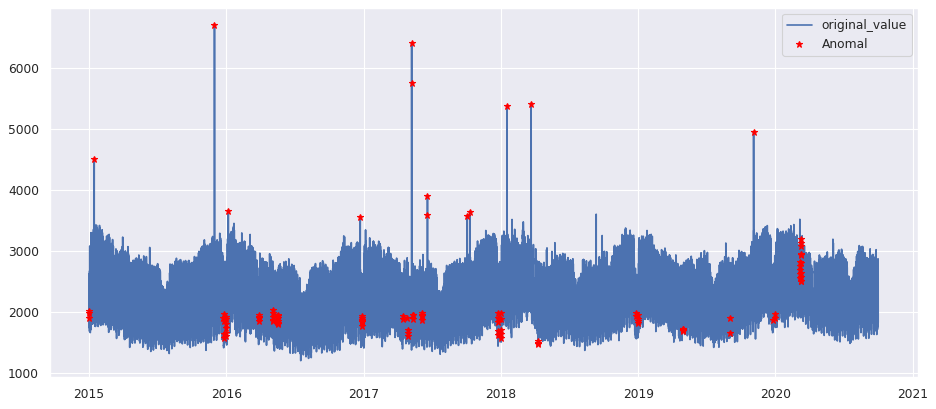

In [144]:
from adtk.detector import SeasonalAD
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(df[['entsoe']])

df2 = df.copy()
df2['a'] = anomalies['entsoe']
df_all = df2[df2['a'] == True].copy()

figure(figsize=(14, 6), dpi=80)
plt.plot(df['entsoe'], label='original_value')
plt.plot(df_all['entsoe'], color='red', marker='*', linestyle='', label='Anomal')
plt.legend()
plt.show();

## InterQuartileRangeAD

InterQuartileRangeAD (детектор аномалий на основе интерквартильного диапазона) - это метод обнаружения аномалий во временных рядах, основанный на интерквартильном диапазоне (IQR).

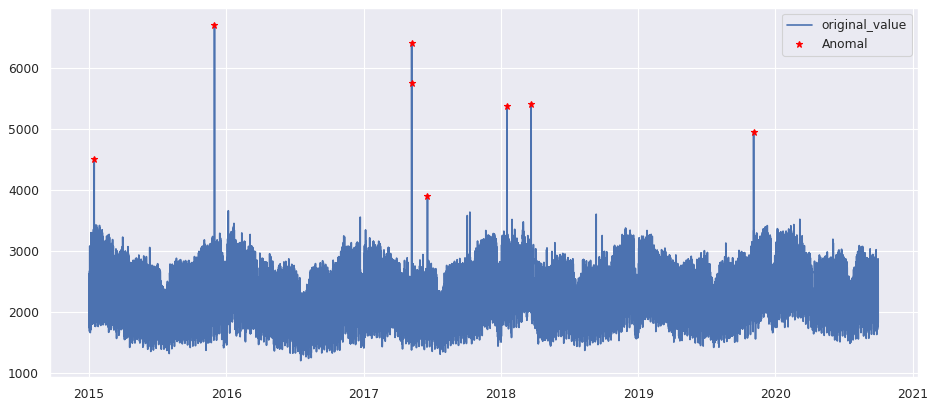

In [146]:
from adtk.detector import InterQuartileRangeAD

iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies_iqr = iqr_ad.fit_detect(df[['entsoe']])

df_iqr = df.copy()
df_iqr['anomalies'] = anomalies_iqr['entsoe']
df_all_iqr = df_iqr[df_iqr['anomalies'] == True].copy()

figure(figsize=(14, 6), dpi=80)
plt.plot(df['entsoe'], label='original_value')
plt.plot(df_all_iqr['entsoe'], color='red', marker='*', linestyle='', label='Anomal')
plt.legend()
plt.show()


## Вывод

* QuantileAD:

  * QuantileAD основан на использовании квантилей для выявления аномалий. Высокие и низкие квантили устанавливают верхний и нижний пороги, и точки данных за пределами этих порогов считаются аномалиями.
  * QuantileAD подходит для обнаружения общих аномалий, не зависящих от времени.
* SeasonalAD:

  * SeasonalAD предназначен для обнаружения сезонных аномалий, которые повторяются в определенные периоды времени. Метод использует характерные сезонные паттерны для выявления отклонений.
  * Полезен при поиске аномалий, связанных с сезонными колебаниями.
* InterQuartileRangeAD:

  * InterQuartileRangeAD использует межквартильный размах (IQR) для определения аномалий. Он опирается на разницу между первым и третьим квартилями данных.
  * Подходит для выявления аномалий, не вписывающихся в типичные распределения данных.



* Можно заметить что в начале каждого из годов видны аномально низкие показатели, наверное это сезонность, высокие показатели могут быть из-за тех. проблем, сбои в работе, либо аномально большая нагрузка.

